## scipy image: cleaning, segmentation, etc. - write timing test
    * details for image patch-segment indices as whole image array
    * Option to leave remainder pixels at image edges is preferred
    * 1000 image write time is more than twice as fast using .jpb vs .png
        * .png 1000 images in about 38 s
        * .jpb 1000 images in about 16 s
****
[API Reference: scikit-image](https://scikit-image.org/docs/dev/api/api.html) <br>
****
[Home: scikit-image aka skimage](https://scikit-image.org/) <br>
[Documentation: scikit-image](https://scikit-image.org/docs/stable/) <br>
[scikit-image on GitHub](https://github.com/scikit-image/scikit-image) <br>
[User Guide: scikit-image](https://scikit-image.org/docs/dev/user_guide) <br>
[Founder-tutor](https://bids.berkeley.edu/resources/videos/scikit-image-image-analysis-python-intermediate) <br>
****
## OpenSlide:
[OpenSlide Wiki](https://github.com/openslide/openslide/wiki) <br>
[OpenSlide api](https://openslide.org/api/python/) <br>
[openslide github](https://github.com/openslide/openslide-python) <br>
[openslide dot org](https://openslide.org/) <br>
[openslide C docs](https://openslide.org/api/openslide_8h.html) <br>

#### Note that os.remove(full file name) must be used to remove all files before os.rmdir(directory path) will work
```python
import os
import tempfile

dirpath = tempfile.mkdtemp()
print('directory exists ? ',os.path.isdir(dirpath))
if os.path.isdir(dirpath):
    print(dirpath)
    os.rmdir(dirpath)
    print('directory still exists ? ',os.path.isdir(dirpath))
```
```bash
directory exists ?  True
/var/folders/gf/ybz3wzn55m139k_4dw2v_tvm0000gn/T/tmp8o6spky6
directory still exists ?  False
```

In [1]:
import os
import time
import glob
import math
import multiprocessing as mp
import itertools
import hashlib
import tempfile

import numpy as np
import openslide
from skimage.filters import threshold_otsu

import PIL

output_dir = '../../DigiPath_MLTK_data/out_to_test'
if os.path.isdir(output_dir) == False:
    os.makedirs(output_dir)
    
OUTPUT_PATH = output_dir
data_dir = '../../DigiPath_MLTK_data/Aperio'
files_list = ['CMU-1-Small-Region.svs', 'CMU-1.svs']
SVS = os.path.join(data_dir, files_list[0])
print('Working with file:', SVS, '\nOutput path:', OUTPUT_PATH)

Working with file: ../../DigiPath_MLTK_data/Aperio/CMU-1-Small-Region.svs 
Output path: ../../DigiPath_MLTK_data/out_to_test


In [2]:
out_dir = '../../DigiPath_MLTK_data/out_to_test'
file_types = ['.jpg']
files_list = []
for maybe_file in os.listdir(out_dir):
    full_path = os.path.join(out_dir, maybe_file)
    if os.path.isfile(full_path):
        _, f_ext = os.path.splitext(maybe_file)
        if f_ext in file_types:
            files_list.append(full_path)

print(len(files_list))

999


### Scaled Numpy array indexing of Pillow Image in context of openslide object:
    * [row (x), col (y)] -------------------------------- cartesian numpy matrix indexing
    * [left, top, right, bottom] ------------------------ pillow image box indexing
    * [level, size=(width, height), location=(col,row)] - openslide get region indexing
    
### Input Availability:
    * initial:
        * file name
        * patch size 
        * target directory
    * from opened file:
        * level_count
        * dimensions
        * level_dimensions
        * level_downsamples
    * from initial arithmetic:
        * 

### Use Cases:
    * 1 WSI & label to TFRecord (or dir images)
    * 2 WSI & AnnotationFile to TFRecord
    * 3 WSI & WSI export registered pair to TFRecord
    * 4 WSI & TFRecord export masked thumbnail ----- Note: requires ref to original file locations

In [3]:
"""                                                 Detail scaling boxes usage 
                                                    overlap, padding, stride, etc
"""
def get_pad_spaced_segmented_length_fence_array(segment_length, length):
    fences = {}
    n_fenced = length // segment_length
    n_remain = 1 + length % segment_length
    paddit = n_remain // n_fenced
    if n_remain == segment_length:
        paddit = 0
        n_remain = 0
        n_fenced = n_fenced + 1
    
    fence_array = np.zeros((n_fenced, 2)).astype(int)
    for k in range(n_fenced):
        if k == 0:
            fence_array[k, 0] = paddit
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        elif fence_array[k-1, 1] + segment_length <= length:
            fence_array[k, 0] = fence_array[k-1, 1] + 1 + paddit
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        
    fences['fence_array'] = fence_array
    fences['n_fenced'] = n_fenced
    fences['n_remain'] = n_remain
    fences['padding'] = paddit

    return fences


def get_adjcent_segmented_length_fence_array(segment_length, length):
    fences = {}
    n_fenced = length // segment_length
    n_remain = 1 + length % segment_length
    paddit = n_remain // 2
    if n_remain == segment_length:
        paddit = 0
        n_remain = 0
        n_fenced = n_fenced + 1
    
    fence_array = np.zeros((n_fenced, 2)).astype(int)
    for k in range(n_fenced):
        if k == 0:
            fence_array[k, 0] = paddit
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        elif fence_array[k-1, 1] + segment_length <= length:
            fence_array[k, 0] = fence_array[k-1, 1] + 1
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        
    fences['fence_array'] = fence_array
    fences['n_fenced'] = n_fenced
    fences['n_remain'] = n_remain
    fences['padding'] = paddit

    return fences

segment_length = 224
length = segment_length*4 - 3

print('\tget_adjcent_segmented_length_fence_array')
print('\tn pixels: %i patch_length: %i\n'%(length, segment_length))
fences_dict = get_adjcent_segmented_length_fence_array(segment_length, length)
for k, v in fences_dict.items():
    if isinstance(v, np.ndarray):
        print('%20s:'%(k))
        for v_idx in range(v.shape[0]):
            if v[v_idx,1] - v[v_idx,0] != segment_length - 1:
                print('%24s, %6i   Bug Bug'%(v[v_idx,0], v[v_idx,1]))
            else:
                print('%24s, %6i'%(v[v_idx,0], v[v_idx,1]))
    else:
        print('%20s: %s'%(k,v))
        
print('\n\n\tget_pad_spaced_segmented_length_fence_array')
print('\tn pixels: %i patch_length: %i\n'%(length, segment_length))
fences_dict = get_pad_spaced_segmented_length_fence_array(segment_length, length)
for k, v in fences_dict.items():
    if isinstance(v, np.ndarray):
        print('%20s:'%(k))
        for v_idx in range(v.shape[0]):
            if v[v_idx,1] - v[v_idx,0] != segment_length - 1:
                print('%24s, %6i   Bug Bug'%(v[v_idx,0], v[v_idx,1]))
            else:
                print('%24s, %6i'%(v[v_idx,0], v[v_idx,1]))
    else:
        print('%20s: %s'%(k,v))

	get_adjcent_segmented_length_fence_array
	n pixels: 893 patch_length: 224

         fence_array:
                     111,    334
                     335,    558
                     559,    782
            n_fenced: 3
            n_remain: 222
             padding: 111


	get_pad_spaced_segmented_length_fence_array
	n pixels: 893 patch_length: 224

         fence_array:
                      74,    297
                     372,    595
                     670,    893
            n_fenced: 3
            n_remain: 222
             padding: 74


In [4]:
"""                                                 Detail scaling boxes usage 
                                                    overlap, padding, stride, etc
"""
#                                               initialize test variables
cell_start_time = time.time()
PATCH_HEIGHT = 224
PATCH_WIDTH = 224
print('%40s: %5i, %5i'%('output patch images size:',PATCH_HEIGHT, PATCH_WIDTH))
target_dir = '../../DigiPath_MLTK_data/out_to_test'
print('output directory:\n\t', os.path.abspath(target_dir))

#                                               open the file
test_file_name = os.path.join(data_dir, 'CMU-1.svs')
print('Opening Image file: \n\t{}\n'.format(test_file_name))
os_obj = openslide.OpenSlide(test_file_name)
pixels_height = os_obj.dimensions[0]
pixels_width = os_obj.dimensions[1]

oneGig = 1e9
print('Image size {} x {}\t{} Giga pixels'.format(pixels_height, pixels_width, 
                                             pixels_height * pixels_width / oneGig))

#                                               read the meta data
pixels_height_ds = os_obj.level_dimensions[-1][0]
pixels_width_ds = os_obj.level_dimensions[-1][1]
print('Thumb size {} x {}\t{} pixels'.format(pixels_height_ds, pixels_width_ds, 
                                             pixels_height_ds * pixels_width_ds))

#                               find the thumbnail size ratio (need pre-trained size)
print('h, w scaling {} x {}'.format(pixels_height / pixels_height_ds, 
                                    pixels_width / pixels_width_ds))
print('obj.level_downsamples', os_obj.level_downsamples)
print('obj.level_downsamples[-1]', os_obj.level_downsamples[-1])
print('obj.level_dimensions', os_obj.level_dimensions)

big_thumb = os_obj.get_thumbnail((pixels_height_ds, pixels_width_ds))
print('big_thumb stats:',type(big_thumb), big_thumb.size, big_thumb.getextrema())

#                                               make the mask
grey_thumbnail = np.array(big_thumb.convert('L'))
thresh = threshold_otsu(grey_thumbnail)
mask = np.array(grey_thumbnail) < thresh
mask_im = PIL.Image.fromarray(np.uint8(mask) * 255)

#                                               make the grid
#                                               make the directory name
_, f_name = os.path.split(test_file_name)
f_name, f_ext = os.path.splitext(f_name)
print('directory name',f_name)

#                               get the ndarrays of full size grid, write as type
full_rows = get_adjcent_segmented_length_fence_array(segment_length=PATCH_HEIGHT, 
                                                     length=pixels_height)
full_cols = get_adjcent_segmented_length_fence_array(segment_length=PATCH_WIDTH, 
                                                     length=pixels_width)

print('\nthumb size:', pixels_height_ds, pixels_width_ds)
print('\nfull size:', pixels_height, pixels_width)

#                                               (save a list of the files)
print('\ncell run time: %0.3f'%(time.time() - cell_start_time))

               output patch images size::   224,   224
output directory:
	 /Users/yo/git_clone/ncsa_genomics/DigiPath_MLTK_data/out_to_test
Opening Image file: 
	../../DigiPath_MLTK_data/Aperio/CMU-1.svs

Image size 46000 x 32914	1.514044 Giga pixels
Thumb size 2875 x 2057	5913875 pixels
h, w scaling 16.0 x 16.000972289742343
obj.level_downsamples (1.0, 4.000121536217793, 16.00048614487117)
obj.level_downsamples[-1] 16.00048614487117
obj.level_dimensions ((46000, 32914), (11500, 8228), (2875, 2057))
big_thumb stats: <class 'PIL.Image.Image'> (2875, 2057) ((0, 255), (0, 255), (3, 255))
directory name CMU-1

thumb size: 2875 2057

full size: 46000 32914

cell run time: 0.420


718 513
0.015608695652173913 0.015586072795770796


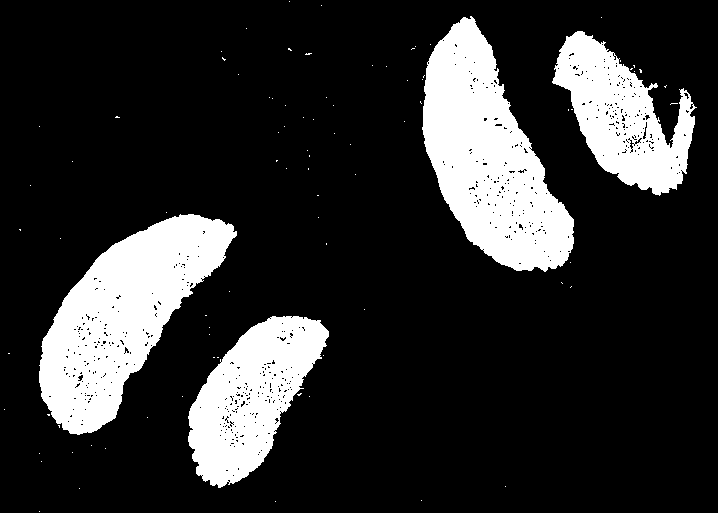

In [5]:
tom_thumb = os_obj.get_thumbnail((pixels_height_ds//4, pixels_width_ds//4))
grey_thumbnail = np.array(tom_thumb.convert('L'))
thresh = threshold_otsu(grey_thumbnail)
mask = np.array(grey_thumbnail) < thresh
mask_im = PIL.Image.fromarray(np.uint8(mask) * 255)

print(mask_im.size[0], mask_im.size[1])
row_scale_down = mask_im.size[0] / pixels_height
col_scale_down = mask_im.size[1] / pixels_width
print(row_scale_down, col_scale_down)
display(mask_im)

In [6]:
"""                           Timing test - write 1000 patch files           """
walk_start_time = time.time()

_, file_name_base = os.path.split(test_file_name)
file_name_base, _ = os.path.splitext(file_name_base)
file_ext = '.jpg'
print('file_name_base', file_name_base, '\nfile extension', file_ext)

keeper_threshold = 0.5
patch_size =(PATCH_WIDTH, PATCH_HEIGHT)
row_fence_array = full_rows['fence_array']
col_fence_array = full_cols['fence_array']
keepers = 0
skippers = 0
time_req_to_open_and_save = 0
n_opened = 0
n_to_open = 1000
for row in range(row_fence_array.shape[0]):
    if row % 10 == 0:
        print('row %3i: %03f'%(row, time.time() - walk_start_time))
        
    for col in range(col_fence_array.shape[0]):
        r = row_fence_array[row]*row_scale_down
        c = col_fence_array[col]*col_scale_down
        area = (c[0], r[0], c[1], r[1])
        thumb_segment = mask_im.crop(area)
        thumb_arr = np.array(thumb_segment)
        mask_value = np.float(np.sum(thumb_arr==0)) / np.float(np.prod(thumb_arr.shape))
        if mask_value > keeper_threshold:
            skippers += 1
        else:
            keepers += 1
            
            if n_to_open > 1:
                n_to_open -= 1
                t0 = time.time()
                rc_location = (col_fence_array[col][0], row_fence_array[row][0])
                full_sect = os_obj.read_region(level=0, size=patch_size, 
                                               location=rc_location)
                
                time_scale = 1e32
                t_int = b'%i'%np.int(t0 * time_scale)
                m = hashlib.sha1()
                m.update(t_int)
                
                small_name = file_name_base + '_row_%i_%i'%(row_fence_array[row][0], 
                                                            row_fence_array[row][1])
                small_name += '_col_%i_%i%s'%(col_fence_array[col][0], 
                                              col_fence_array[col][1], file_ext)
                full_sect = full_sect.convert('RGB')
                
                small_name = os.path.join(output_dir, small_name)
                full_sect.save(small_name)
                
                time_req_to_open_and_save += time.time() - t0
                n_opened += 1
                
average_time_req_to_open_and_save = time_req_to_open_and_save / n_opened
print('tt = %0.3f\nkeepers = %i\nskippers = %i'%(time.time() - walk_start_time, 
                                                 keepers, skippers))
print('average open & write time: %0.3f'%(average_time_req_to_open_and_save))
print('estimated total time: %0.2f'%(keepers*average_time_req_to_open_and_save))

file_name_base CMU-1 
file extension .jpg
row   0: 0.000684
row  10: 0.325100
row  20: 1.402735
row  30: 2.694014
row  40: 4.396064
row  50: 5.586850
row  60: 6.194633
row  70: 6.290580
row  80: 6.370989
row  90: 6.492965
row 100: 6.617311
row 110: 6.693464
row 120: 6.780380
row 130: 6.878523
row 140: 6.973508
row 150: 7.073138
row 160: 7.169750
row 170: 7.262125
row 180: 7.362951
row 190: 7.459723
row 200: 7.559219
tt = 7.609
keepers = 4208
skippers = 25722
average open & write time: 0.005
estimated total time: 23.08


### Run with 1000 images written:
#### 4 -- jpg
```text
tt = 8.211
keepers = 4208
skippers = 25722
average open & write time: 0.006
estimated total time: 25.83
```
#### 3 -- jpg
```text
tt = 7.982
keepers = 4208
skippers = 25722
average open & write time: 0.006
estimated total time: 24.97
```
#### 2 -- png
```text
    tt = 37.083
    keepers = 4208
    skippers = 25722
    average open & write time: 0.035
    estimated total time: 147.00
```
#### 1 -- png
```text
    tt = 37.984
    keepers = 4208
    skippers = 25722
    average open & write time: 0.036
    estimated total time: 150.65
```

In [7]:
out_test_dir = '../../DigiPath_MLTK_data/out_to_test'
jpg_list = []
for f in os.listdir(out_test_dir):
    _, f_ext = os.path.splitext(f)
    if f_ext == '.jpg':
        full_name = os.path.join(out_test_dir, f)
        if full_name in jpg_list:
            print('duplicate name: ???', full_name)
        else:
            jpg_list.append(full_name)
        
print(len(jpg_list))

# dictionary from files list:
image_labels = {}

for file_number in range(len(jpg_list)):
    image_labels[jpg_list[file_number]] = file_number
    
print(len(image_labels))
jpg_list[:10]

999
999


['../../DigiPath_MLTK_data/out_to_test/CMU-1_row_10568_10791_col_28329_28552.jpg',
 '../../DigiPath_MLTK_data/out_to_test/CMU-1_row_11016_11239_col_30569_30792.jpg',
 '../../DigiPath_MLTK_data/out_to_test/CMU-1_row_4744_4967_col_27433_27656.jpg',
 '../../DigiPath_MLTK_data/out_to_test/CMU-1_row_10792_11015_col_28105_28328.jpg',
 '../../DigiPath_MLTK_data/out_to_test/CMU-1_row_7656_7879_col_29001_29224.jpg',
 '../../DigiPath_MLTK_data/out_to_test/CMU-1_row_2728_2951_col_30569_30792.jpg',
 '../../DigiPath_MLTK_data/out_to_test/CMU-1_row_8552_8775_col_28329_28552.jpg',
 '../../DigiPath_MLTK_data/out_to_test/CMU-1_row_7432_7655_col_29897_30120.jpg',
 '../../DigiPath_MLTK_data/out_to_test/CMU-1_row_7432_7655_col_30569_30792.jpg',
 '../../DigiPath_MLTK_data/out_to_test/CMU-1_row_2952_3175_col_28777_29000.jpg']

In [8]:
for k, v in full_rows.items():
    if isinstance(v, np.ndarray):
        print('%20s:'%(k))
        for v_idx in range(v.shape[0]):
            if v[v_idx,1] - v[v_idx,0] != PATCH_HEIGHT - 1:
                print('%24s, %6i   Bug Bug'%(v[v_idx,0], v[v_idx,1]))
            else:
                print('%24s, %6i'%(v[v_idx,0], v[v_idx,1]))
    else:
        print('%20s: %s'%(k,v))

         fence_array:
                      40,    263
                     264,    487
                     488,    711
                     712,    935
                     936,   1159
                    1160,   1383
                    1384,   1607
                    1608,   1831
                    1832,   2055
                    2056,   2279
                    2280,   2503
                    2504,   2727
                    2728,   2951
                    2952,   3175
                    3176,   3399
                    3400,   3623
                    3624,   3847
                    3848,   4071
                    4072,   4295
                    4296,   4519
                    4520,   4743
                    4744,   4967
                    4968,   5191
                    5192,   5415
                    5416,   5639
                    5640,   5863
                    5864,   6087
                    6088,   6311
                    6312,   6535
                    6

## The crop rectangle, as a (left, upper, right, lower)-tuple.
```python

from PIL import ImageOps

border = (0, 30, 0, 30) 
# (left, top, right, bottom),  [x[0], y[0], x[1], y[1]],  (col_1, row_1, col_end, row_end)
ImageOps.crop(img, border)

## vs

from PIL import Image

img = Image.open("ImageName.jpg")
area = (400, 400, 800, 800)
cropped_img = img.crop(area)
cropped_img.show()
```


```python
MAXPATCHESTOWRITE = 1000
import glob
import math
import os
import numpy as np
import openslide
from skimage.filters import threshold_otsu

def get_thumbnail(img, x_level0, y_level0, patch_size, output_path):
    patch = img.read_region((x_level0, y_level0), 0, (patch_size, patch_size))
    patch = patch.convert('RGB')
    fname = img.properties['aperio.Filename'].replace(' ', '_')
    fname += '_' + str(x_level0)
    fname += '_' + str(y_level0)
    fname += '_' + '0'
    fname += '_' + str(patch_size)
    fname += '.jpg'
    patch_arr = np.array(patch.convert('L'))
    if np.average(patch_arr) < 230:
        global num_patches
        num_patches += 1
        patch.save(os.path.join(output_path, fname))

def process_svs(SVS,
                normalization_factor=1000,
                patch_size=512,
                buffer=10,
                output_path=OUTPUT_PATH):
    img = openslide.OpenSlide(SVS)

    global num_patches
    num_patches = 0

    x_max, y_max = img.dimensions
    thumbnail = img.get_thumbnail((normalization_factor, normalization_factor))

    grey_thumbnail = np.array(thumbnail.convert("L"))
    thresh = threshold_otsu(grey_thumbnail)
    mask = np.array(grey_thumbnail) < thresh

    # how many pixels in the raw image per pixel in mask
    x_num_orgPix_per_thumbPix = math.ceil(x_max / mask.shape[0])
    y_num_orgPix_per_thumbPix = math.ceil(y_max / mask.shape[1])
    # print(x_num_orgPix_per_thumbPix, y_num_orgPix_per_thumbPix)

    # Find out how many pixels in image mask to count as a patch in original
    num_x_mask_pixels_per_rawPatch = math.ceil(patch_size / x_num_orgPix_per_thumbPix)
    num_y_mask_pixels_per_rawPatch = math.ceil(patch_size / y_num_orgPix_per_thumbPix)
    # print(num_x_mask_pixels_per_rawPatch, num_y_mask_pixels_per_rawPatch)

    mask_x, mask_y = mask.shape
    x_mask_prev = 0

    # Iterate through the mask to identify positive pixels
    for x in range(buffer, mask_x - buffer):
        x_mask_window = x + num_x_mask_pixels_per_rawPatch
        if x_mask_window <= x_mask_prev:
            continue
        y_mask_prev = 0
        for y in range(buffer, mask_y - buffer):
            y_mask_window = y + num_y_mask_pixels_per_rawPatch
            # print('Evaluate: {} {} & {}'.format(y, y_mask_window, y_mask_prev))
            if y_mask_window <= y_mask_prev:
                continue
            if y % 100 == 0:
                print('X: {}\tY:{} of {} with total of {} so far'.format(x, y, 
                                                                         mask.shape, 
                                                                         num_patches), end='\r',
                                                                  flush=True)
                
            if np.sum(mask[x:x_mask_window, y:y_mask_window]) > 0:
                # convert mask coordinates to level0 coordinates
                x_level0 = x * x_num_orgPix_per_thumbPix
                y_level0 = y * y_num_orgPix_per_thumbPix
                get_thumbnail(img, x_level0, y_level0, patch_size, output_path)
                
                #                                      <0><0>          Limit number of files
                if num_patches >= MAXPATCHESTOWRITE:
                    print('\n\n\t{} num_patched out\n\n'.format(num_patches))
                    return
                #                                      <0><0>

            # print('yamsk windoe: {}'.format(y_mask_window))
            y_mask_prev = y_mask_window
        x_mask_prev = x_mask_window

    print('Printed {} from {}'.format(num_patches, SVS))

num_patches = 0
"""
# if __name__ == '__main__':
#     for SVS in glob.glob('/data/biliary/svs/negative/*svs'):
#         process_svs(SVS)
"""
print('processing: {}'.format(SVS))
process_svs(SVS)
```